# NAME- HARSHIT
# MASTER'S IN MATHEMATICS(1st year)
# ENROLLMENT NO - 23616010

In [27]:
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import torch
seed = 7777
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import torch.nn as nn
import torchvision
from tqdm import tqdm
import numpy as np
device = "cuda" if torch.cuda.is_available() else "cpu"


In [30]:
class ImageEncoder(nn.Module):
    def __init__(self, no_of_classes):
        super().__init__()
        pretrained_weights = torchvision.models.ResNet152_Weights.DEFAULT
        pretrained_model = torchvision.models.resnet152(weights=pretrained_weights)
        for parameter in pretrained_model.parameters():
            parameter.requires_grad = True
        pretrained_model.fc = nn.Linear(in_features=2048, out_features=no_of_classes)
        self.model = pretrained_model

    def forward(self, x):
        x = self.model(x)
        return x


class ImageClassification():
    def __init__(self, model):
        self.model = model

    def __call__(self, train_data, val_data, epochs=64, patience=5, savepath=None):
        self.random_seed()
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=0.001)
        val_acc = []
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(device)
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            correct = 0
            total = 0
            for image, labels in tqdm(train_data, desc=f'Epoch {epoch + 1}/{epochs}: Training'):
                optimizer.zero_grad()
                outputs = self.model(image.to(device))
                loss = criterion(outputs.to(device), labels.to(device))
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels.to(device)).sum().item()
            train_accuracy = 100 * correct / total
            train_loss = train_loss / (total / 64)
            print(f'Epoch {epoch + 1}/{epochs}:')
            print(f'Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}%')
            self.model.eval()
            val_loss = 0
            correct = 0
            total = 0
            with torch.no_grad():
                for image, labels in tqdm(val_data, desc=f'Epoch {epoch + 1}/{epochs}: Evaluating'):
                    outputs = self.model(image.to(device))
                    loss = criterion(outputs.to(device), labels.to(device))
                    val_loss += loss.item()
                    _, predicted = outputs.max(1)
                    total += labels.size(0)
                    correct += predicted.eq(labels.to(device)).sum().item()
                val_accuracy = 100 * correct / total
                val_loss = val_loss / (total / 64)
            print(f'Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}%')

            if val_accuracy > (max(val_acc) if len(val_acc) != 0 else 0) and savepath:
                filename = f'model-epoch${epoch+1}-train_loss${train_loss:.4f}-train_acc${train_accuracy:.4f}-val_loss${val_loss:.4f}-val_acc${val_accuracy:.4f}.pth'
                ImageClassification.clear_directory(savepath)
                torch.save(self.model.state_dict(), os.path.join(savepath,filename))
                print(f'Validation accuracy improved from {max(val_acc) if len(val_acc) != 0 else 0:.4f} to {val_accuracy:.4f}....')
            val_acc.append(val_accuracy)

            if ImageClassification.patience_exceed(val_acc,patience):
                print(f'Early stopping after {patience} epochs with no improvement in validation accuracy. Maximum validation accuracy is {np.round(np.max(val_acc),4)} on epoch {np.argmax(val_acc)+1}')
                break
            filename = f'trained_model.pth'
            ImageClassification.clear_directory(savepath)
            torch.save(self.model.state_dict(), os.path.join(savepath,filename))


    def random_seed(self):
        seed = 7777
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)

    @staticmethod
    def patience_exceed(data,indexes):
        if indexes == None:
            return False
        if data[:-indexes] == [] or data[-indexes:] == []:
            return False
        lower = max(data[:-indexes])
        upper = max(data[-indexes:])
        if upper > lower:
            return False
        else:
            return True

    @staticmethod
    def clear_directory(path):
        if os.path.exists(path):
            for datas in os.listdir(path):
                files = os.path.join(path,datas)
                if os.path.isfile(files):
                    os.remove(os.path.join(path,files))
                elif os.path.isdir(files):
                    shutil.rmtree(os.path.join(path,files))
                elif os.path.islink(files):
                    os.unlink(os.path.join(path,files))
        else:
            os.makedirs(path)


In [31]:
num_of_classes = 5

In [32]:
!pip install torchinfo
from torchinfo import summary

# Print a summary using torchinfo (uncomment for actual output)
summary(model=ImageEncoder(num_of_classes),
        input_size=(64, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
ImageEncoder (ImageEncoder)                   [64, 3, 224, 224]    [64, 5]              --                   True
├─ResNet (model)                              [64, 3, 224, 224]    [64, 5]              --                   True
│    └─Conv2d (conv1)                         [64, 3, 224, 224]    [64, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (bn1)                      [64, 64, 112, 112]   [64, 64, 112, 112]   128                  True
│    └─ReLU (relu)                            [64, 64, 112, 112]   [64, 64, 112, 112]   --                   --
│    └─MaxPool2d (maxpool)                    [64, 64, 112, 112]   [64, 64, 56, 56]     --                   --
│    └─Sequential (layer1)                    [64, 64, 56, 56]     [64, 256, 56, 56]    --                   True
│    │    └─Bottleneck (0)                    [64, 64, 56, 56]     [64, 256, 56, 56]   

In [33]:
# Setup directory paths to train and validation images
train_dir = '/content/drive/MyDrive/Image Data/cross_val_2/train'
val_dir = '/content/drive/MyDrive/Image Data/cross_val_2/val'
test_dir = '/content/drive/MyDrive/Image Data/cross_val_2/test'



In [34]:
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader


def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
):

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    val_data = datasets.ImageFolder(val_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

In [35]:
def create_dataloaders(
    train_dir: str,
    val_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
):

    # Use ImageFolder to create dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    val_data = datasets.ImageFolder(val_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      pin_memory=True,
    )
    val_dataloader = DataLoader(
      val_data,
      batch_size=batch_size,
      shuffle=False,
      pin_memory=True,
    )
    test_dataloader = DataLoader(
      test_data,
      batch_size=len(test_data),
      shuffle=False,
      pin_memory=True,
    )

    return train_dataloader, val_dataloader, test_dataloader, class_names


In [36]:
transforms = torchvision.models.ResNet152_Weights.DEFAULT.transforms()

In [37]:
#Setup dataloaders
train_dataloader_pretrained, test_dataloader_pretrained,val_dataloader_pretrained, class_names = create_dataloaders(train_dir=train_dir,
                                                                                          test_dir=test_dir,
                                                                                          val_dir=val_dir,
                                                                                          transform=transforms,
                                                                                          batch_size=64) # Could increase if we had more samples, such as here: https://arxiv.org/abs/2205.01580 (there are other improvements there too...)


In [38]:
model_img = ImageEncoder(num_of_classes)
model = ImageClassification(model_img)
model(train_dataloader_pretrained, val_dataloader_pretrained,epochs=16,patience=1,savepath = '/tf/results1/RESNET-2')

Epoch 1/16: Training: 100%|██████████| 48/48 [10:37<00:00, 13.27s/it]


Epoch 1/16:
Train Loss: 0.4988 | Train Accuracy: 84.3362%


Epoch 1/16: Evaluating: 100%|██████████| 1/1 [01:21<00:00, 81.76s/it]


Validation Loss: 0.1229 | Validation Accuracy: 82.0779%
Validation accuracy improved from 0.0000 to 82.0779....


Epoch 2/16: Training: 100%|██████████| 48/48 [01:41<00:00,  2.11s/it]


Epoch 2/16:
Train Loss: 0.2964 | Train Accuracy: 90.6475%


Epoch 2/16: Evaluating: 100%|██████████| 1/1 [00:06<00:00,  6.28s/it]


Validation Loss: 0.0571 | Validation Accuracy: 88.3117%
Validation accuracy improved from 82.0779 to 88.3117....


Epoch 3/16: Training: 100%|██████████| 48/48 [01:40<00:00,  2.10s/it]


Epoch 3/16:
Train Loss: 0.1977 | Train Accuracy: 94.0811%


Epoch 3/16: Evaluating: 100%|██████████| 1/1 [00:05<00:00,  5.72s/it]

Validation Loss: 0.1340 | Validation Accuracy: 79.2208%
Early stopping after 1 epochs with no improvement in validation accuracy. Maximum validation accuracy is 88.3117 on epoch 2


In [39]:
state_dict = torch.load('/tf/results1/RESNET-2/trained_model.pth')
model1 = ImageEncoder(num_of_classes)
model1.load_state_dict(state_dict)
model1.to(device)
model1.eval()
# model = torch.load(state_dict)
correct = 0
total = 0
with torch.no_grad():
    for image, labels in tqdm(test_dataloader_pretrained,desc='Testing'):
        print(image.shape)
        outputs = model1(image.to(device))
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels.to(device)).sum().item()
    val_accuracy = 100 * correct / total
print(f'Testing Accuracy: \033[32m\033[1m{val_accuracy:.4f}%\033[0m')

Testing:   0%|          | 0/6 [00:00<?, ?it/s]

torch.Size([64, 3, 224, 224])


Testing:  17%|█▋        | 1/6 [00:14<01:11, 14.29s/it]

torch.Size([64, 3, 224, 224])


Testing:  33%|███▎      | 2/6 [00:27<00:55, 13.83s/it]

torch.Size([64, 3, 224, 224])


Testing:  50%|█████     | 3/6 [00:41<00:40, 13.65s/it]

torch.Size([64, 3, 224, 224])


Testing:  67%|██████▋   | 4/6 [00:56<00:28, 14.12s/it]

torch.Size([64, 3, 224, 224])


Testing:  83%|████████▎ | 5/6 [01:09<00:13, 13.70s/it]

torch.Size([61, 3, 224, 224])


Testing: 100%|██████████| 6/6 [01:22<00:00, 13.68s/it]

Testing Accuracy: 89.5013%


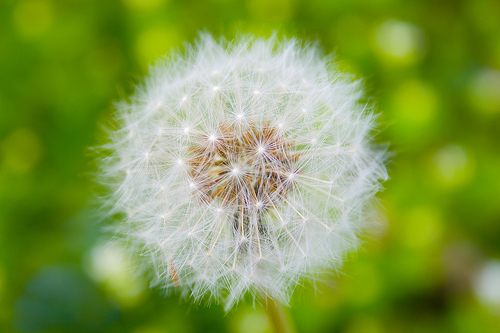

Class is:  dandelion


In [40]:
#Test results
# %matplotlib inline
img_path = '/content/drive/MyDrive/test.jpg'
from PIL import Image
img = Image.open(img_path)
imgx = transforms(img).unsqueeze(0).to(device)
result = model1(imgx).argmax().detach().item()
display(img)
print('Class is: ',class_names[result])